# Facies Classification using ML 

A machine learning algorithm is run to predict facies from well log data. 
The dataset used is log data from nine wells that have been labeled with a facies type based on oberservation of core. this log data is used to train a support vector machine to classify facies types. Support vector machines (or SVMs) are a type of supervised learning model that can be trained on data to perform classification and regression tasks. The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (or facies, in our case). SVM implementation is done in scikit-learn.

First work is to explore the dataset. The training data is loaded from 9 wells. 

Next conditioning of the data set is done . Entries that have incomplete data is removed. The data is scaled to have zero mean and unit variance. And then data is split into training and test sets.

Then SVM classifier model is run . 

Finally, when classifier is built, we can apply the trained model to classify facies in wells which do not already have labels. 

# Exploring the dataset

The training data is contained in the file facies_vectors.csv. The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals. In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)


filename = 'facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.

The seven predictor variables are:

- Five wire line log curves include gamma ray (GR), resistivity logging (ILD_log10), photoelectric effect (PE), neutron-density porosity difference and average neutron-density porosity (DeltaPHI and PHIND). Note, some wells do not have PE.
- Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are:

1. Nonmarine sandstone
2. Nonmarine coarse siltstone
3. Nonmarine fine siltstone
4. Marine siltstone and shale
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

In [2]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', ..., 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots.

We also create the abbreviated facies labels, and add those to the facies_vectors dataframe.

In [3]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [4]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

In [5]:
def make_facies_log_plot(logs, facies_colors):
    #logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when facies classification model is applied to other wells. The function was written to take a list of colors and facies labels as parameters.

Then log plots for wells SHRIMPLIN and SHANKLE is drwan

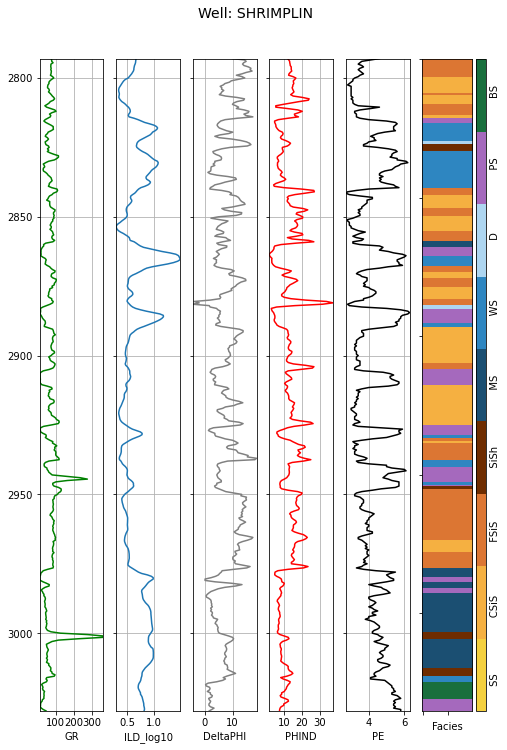

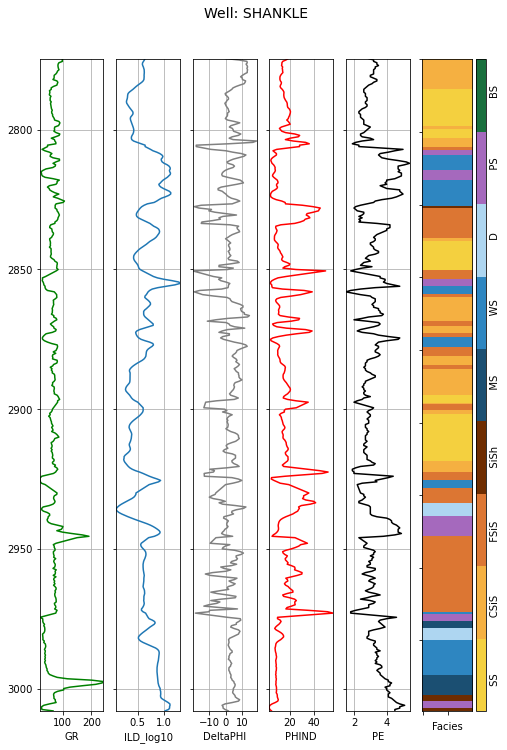

In [6]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHANKLE'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set. Let's plot a histgram of the number of training examples for each facies class.

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

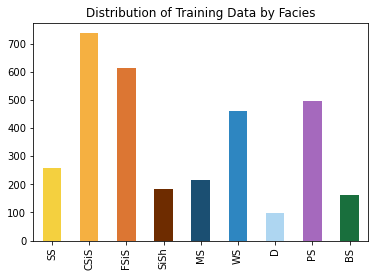

In [7]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

Distribution of examples by facies for the 3232 training examples in the training set. Dolomite (facies 7) has the fewest with 141 examples. There are also only 185 bafflestone examples. Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type. This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset. We can employ the very useful Seaborn library to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies. The same colormap is used to represent the 9 facies.

C:\Users\Rachit kumar.LAPTOP-OP2VFO8E\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\Rachit kumar.LAPTOP-OP2VFO8E\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\Rachit kumar.LAPTOP-OP2VFO8E\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\Rachit kumar.LAPTOP-OP2VFO8E\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\Rachit kumar.LA

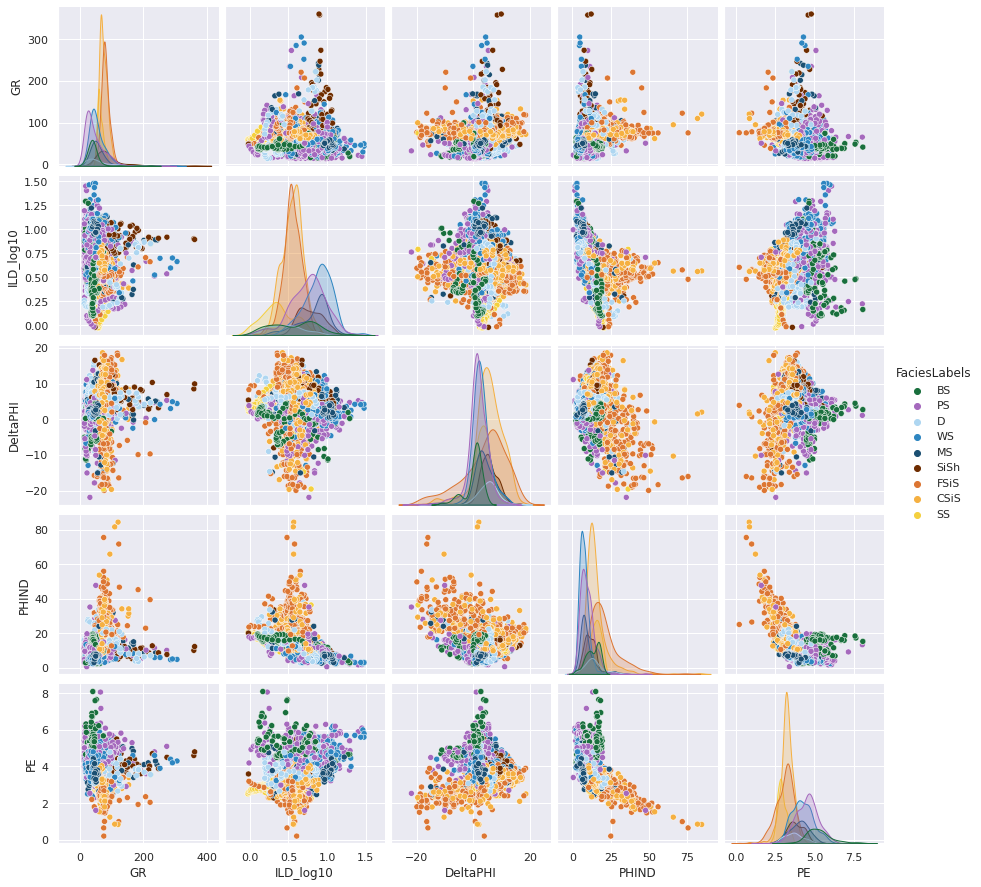

In [8]:
#save the plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

# Conditioning the data set
Now we extract just the feature variables we need to perform the classification. The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [9]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


Scikit includes a preprocessing module that can 'standardize' the data (giving each variable zero mean and unit variance, also called whitening). 
The StandardScalar class can be fit to the training set, and later used to standardize any training data.

In [10]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [51]:
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,51.469,0.965,3.083,7.708,3.152,2,0.661


Scikit also includes a handy function to randomly split the training data into training and test sets. The test set contains a small subset of feature vectors that are not used to train the network. Because the true facies labels for these examples can also be compared the results of the classifier to the actual facies and determine the accuracy of the model. Here I use 20% of the data for the test set.

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

# Training the SVM classifier
Now  the cleaned and conditioned training set to create a facies classifier.The SVM is a map of the feature vectors as points in a multi dimensional space, mapped so that examples from different facies are divided by a clear gap that is as wide as possible.

The SVM implementation in scikit-learn takes a number of important parameters. First one is a classifier using the default settings.

In [55]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train,y_train)

SVC()

In [56]:
predicted_labels = clf.predict(X_test)

In [57]:
# To simplify reading the confusion matrix, 
# a function has been written to display the matrix along with facies labels and various error metrics.
def display_cm(cm, labels, hide_zeros=False,
                             display_metrics=False):
    """Display confusion matrix with labels, along with
       metrics such as Recall, Precision and F1 score.
       Based on Zach Guo's print_cm gist at
       https://gist.github.com/zachguo/10296432
    """

    precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
    recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')
    F1 = 2 * (precision * recall) / (precision + recall)
    
    precision[np.isnan(precision)] = 0
    recall[np.isnan(recall)] = 0
    F1[np.isnan(F1)] = 0
    
    total_precision = np.sum(precision * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_recall = np.sum(recall * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_F1 = np.sum(F1 * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    #print total_precision
    
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + " Pred", end=' ')
    for label in labels: 
        print("%{0}s".format(columnwidth) % label, end=' ')
    print("%{0}s".format(columnwidth) % 'Total')
    print("    " + " True")
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)): 
            cell = "%{0}d".format(columnwidth) % cm[i, j]
            if hide_zeros:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            print(cell, end=' ')
        print("%{0}d".format(columnwidth) % sum(cm[i,:]))
        
        if display_metrics:
            print()
        print("Precision", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % precision[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_precision)
        print("   Recall", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % recall[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_recall)
        print("       F1", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % F1[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_F1)
        
                  
def display_adj_cm(
    cm, labels, adjacent_facies, hide_zeros=False, 
        display_metrics=False):
    """This function displays a confusion matrix that counts 
       adjacent facies as correct.
    """
    adj_cm = np.copy(cm)
    
    for i in np.arange(0,cm.shape[0]):
        for j in adjacent_facies[i]:
            adj_cm[i][i] += adj_cm[i][j]
            adj_cm[i][j] = 0.0
        
    display_cm(adj_cm, labels, hide_zeros, 
                             display_metrics)

In [63]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    24    20     2                                        46
Precision  0.86  0.68  0.68  0.45  0.25  0.57  0.60  0.58  0.89  0.63
   Recall  0.52  0.75  0.71  0.64  0.02  0.69  0.41  0.69  0.77  0.64
       F1  0.65  0.71  0.70  0.53  0.04  0.62  0.49  0.63  0.83  0.62
     CSiS     2   114    36                       1               153
Precision  0.86  0.68  0.68  0.45  0.25  0.57  0.60  0.58  0.89  0.63
   Recall  0.52  0.75  0.71  0.64  0.02  0.69  0.41  0.69  0.77  0.64
       F1  0.65  0.71  0.70  0.53  0.04  0.62  0.49  0.63  0.83  0.62
     FSiS     2    31    90     1     1     1                     126
Precision  0.86  0.68  0.68  0.45  0.25  0.57  0.60  0.58  0.89  0.63
   Recall  0.52  0.75  0.71  0.64  0.02  0.69  0.41  0.69  0.77  0.64
       F1  0.65  0.71  0.70  0.53  0.04  0.62  0.49  0.63  0.83  0.62
     SiSh                 2    18           7           1          28
Precision 

In [64]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [65]:
# The error within these 'adjacent facies' can also be calculated. 
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

<ipython-input-65-85398bbd3c99>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])


In [66]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.639876
Adjacent facies classification accuracy = 0.916538


# Model parameter selection

I consider two parameters. The parameter C is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples. A large value of C will try to correctly classify more examples from the training set, but if C is too large it may 'overfit' the data and fail to generalize when classifying new data. If C is too small then the model will not be good at fitting outliers and will have a large error on the training set.

The SVM learning algorithm uses a kernel function to compute the distance between feature vectors. Many kernel functions exist, but here radial basis function rbf kernel (the default) is used. The gamma parameter describes the size of the radial basis functions, which is how far away two vectors in the feature space need to be to be considered close.

We will train a series of classifiers with different values for C and gamma. Two nested loops are used to train a classifier for every possible combination of values in the ranges specified. The classification accuracy is recorded for each combination of parameter values. The results are shown in a series of plots, so the parameter values that give the best classification accuracy on the test set can be selected.

This process is also known as 'cross validation'. Often a separate 'cross validation' dataset will be created in addition to the training and test sets to do model selection.

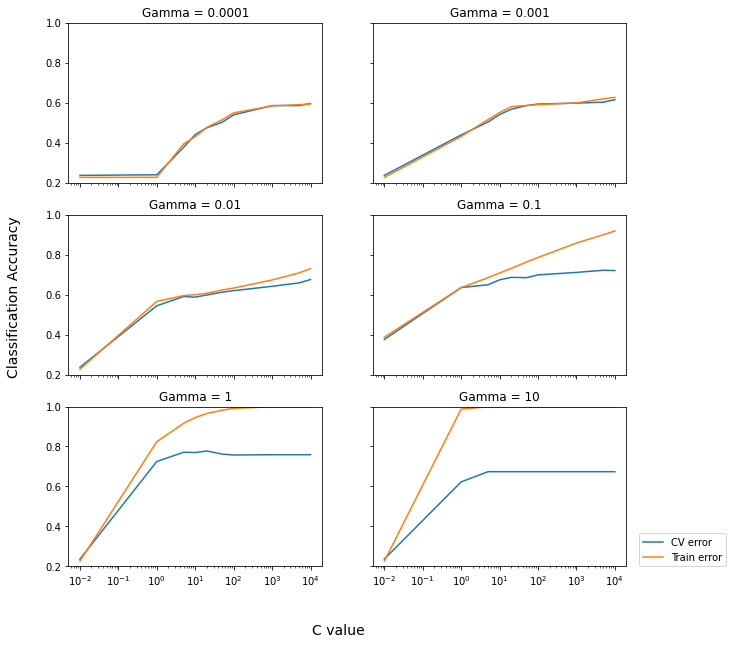

In [67]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

In [68]:
clf = svm.SVC(C=10, gamma=1)        
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.77
Optimized adjacent facies classification accuracy = 0.94


In [69]:
display_cm(cv_conf, facies_labels,display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    36    10                                              46

Precision  0.80  0.79  0.78  0.59  0.77  0.75  1.00  0.73  0.94  0.78
   Recall  0.78  0.82  0.78  0.86  0.57  0.74  0.55  0.74  1.00  0.77
       F1  0.79  0.81  0.78  0.70  0.66  0.74  0.71  0.74  0.97  0.77
     CSiS     7   126    19                 1                     153

Precision  0.80  0.79  0.78  0.59  0.77  0.75  1.00  0.73  0.94  0.78
   Recall  0.78  0.82  0.78  0.86  0.57  0.74  0.55  0.74  1.00  0.77
       F1  0.79  0.81  0.78  0.70  0.66  0.74  0.71  0.74  0.97  0.77
     FSiS     2    23    98     1           1           1         126

Precision  0.80  0.79  0.78  0.59  0.77  0.75  1.00  0.73  0.94  0.78
   Recall  0.78  0.82  0.78  0.86  0.57  0.74  0.55  0.74  1.00  0.77
       F1  0.79  0.81  0.78  0.70  0.66  0.74  0.71  0.74  0.97  0.77
     SiSh                 1    24     1     1           1          28

Precis

In [70]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    46                                                    46

Precision  0.96  0.99  0.93  0.66  0.95  0.97  1.00  0.93  0.97  0.95
   Recall  1.00  0.99  0.96  0.89  0.87  0.91  0.91  0.88  1.00  0.94
       F1  0.98  0.99  0.95  0.76  0.91  0.94  0.95  0.91  0.98  0.94
     CSiS         152                       1                     153

Precision  0.96  0.99  0.93  0.66  0.95  0.97  1.00  0.93  0.97  0.95
   Recall  1.00  0.99  0.96  0.89  0.87  0.91  0.91  0.88  1.00  0.94
       F1  0.98  0.99  0.95  0.76  0.91  0.94  0.95  0.91  0.98  0.94
     FSiS     2         121     1           1           1         126

Precision  0.96  0.99  0.93  0.66  0.95  0.97  1.00  0.93  0.97  0.95
   Recall  1.00  0.99  0.96  0.89  0.87  0.91  0.91  0.88  1.00  0.94
       F1  0.98  0.99  0.95  0.76  0.91  0.94  0.95  0.91  0.98  0.94
     SiSh                 1    25           1           1          28

Precis

# Applying the classification model to new data


This dataset is similar to the training data except it does not have facies labels. It is loaded into a dataframe called test_data.

In [71]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

The data needs to be scaled using the same constants we used for the training data.

In [72]:
X_unknown = scaler.transform(well_features)

Finally  predicted facies labels for the unknown data, is sored in a Facies column of the test_data dataframe.

In [73]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


In [74]:
well_data['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['STUART', 'CRAWFORD']

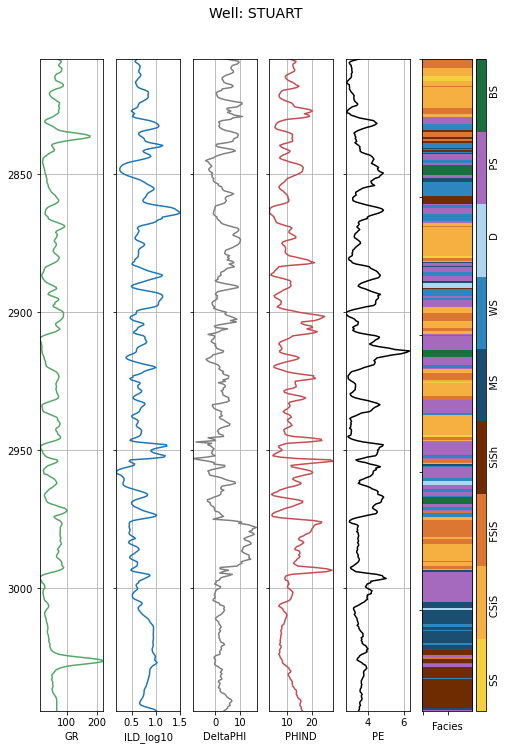

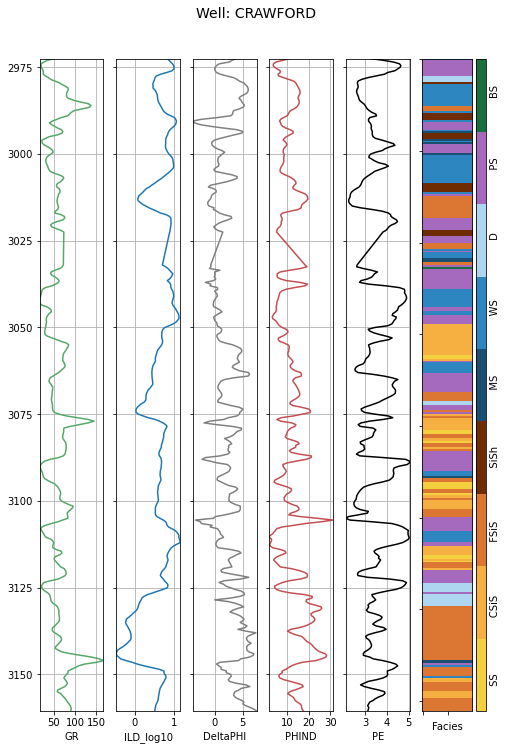

In [75]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

In [76]:
well_data.to_csv('well_data_with_facies.csv')